In [ ]:
# Upload kaggle.json
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [ ]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [ ]:
# Setup Kaggle environment
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# Download dataset
!kaggle datasets download -d yasinpratomo/wound-dataset

 86% 12.0M/13.9M [00:01<00:00, 17.6MB/s]
100% 13.9M/13.9M [00:01<00:00, 11.6MB/s]


In [ ]:
# ekstraksi file zip
import zipfile
local_zip = 'wound-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/wound-dataset')
zip_ref.close()

In [ ]:
# hapus file zip
!rm wound-dataset.zip

In [ ]:
# Direktori utama dataset
base_dir = '/content/wound-dataset/Wound_dataset'

In [ ]:
print(os.listdir(base_dir))

['Ingrown_nails', 'Abrasions', 'Cut', 'Stab_wound', 'Burns', 'Laceration', 'Bruises']


In [ ]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
  counting = len(os.listdir(os.path.join(base_dir, i)))
  number_label[i] = counting
  total_files += counting

print("Total Files : " + str(total_files))

Total Files : 431


Text(0, 0.5, 'Jumlah Gambar')

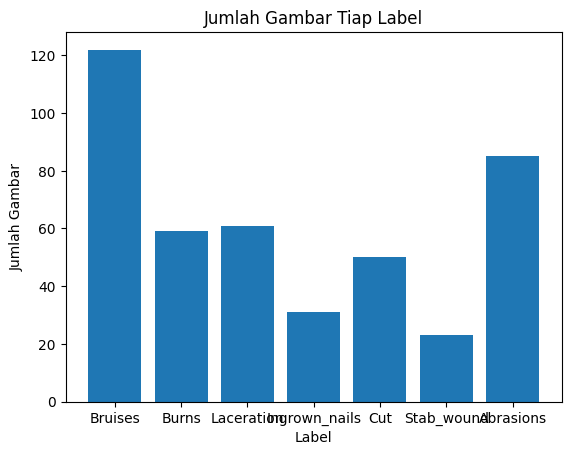

In [ ]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values())
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')

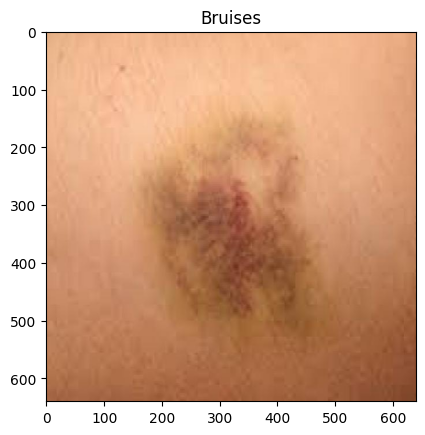

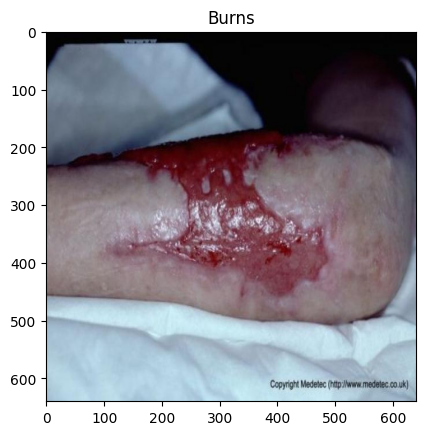

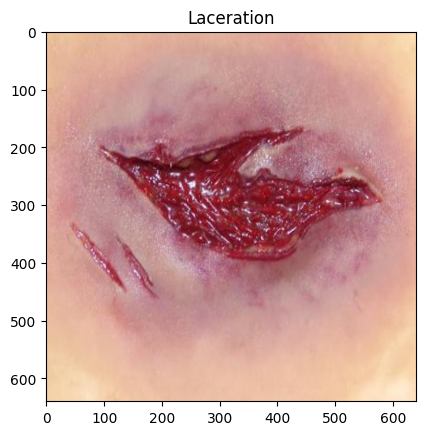

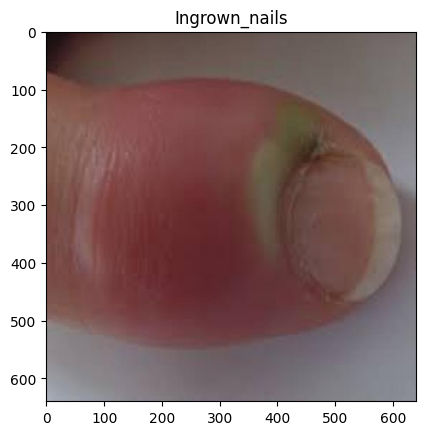

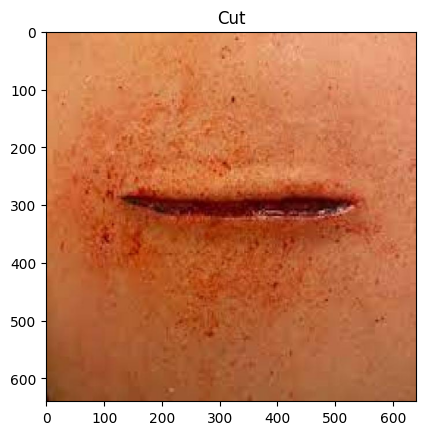

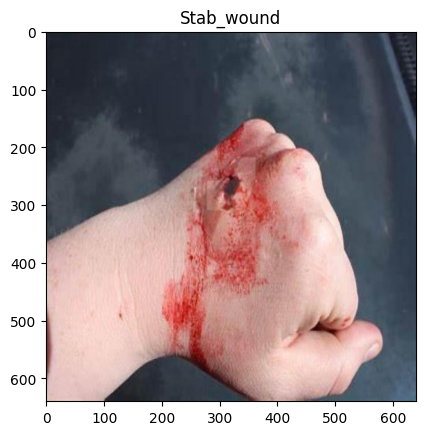

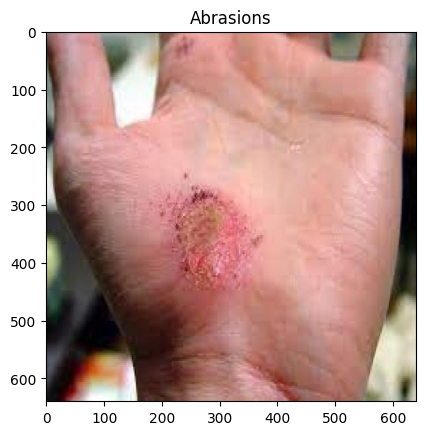

In [ ]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())

for c in classes:
  temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
  for item in temp:
    img_path = os.path.join(base_dir, c, item)
    img_samples[c] = img_path

for i in img_samples:
  fig = plt.gcf()
  img = mpimg.imread(img_samples[i])
  plt.title(i)
  plt.imshow(img)
  plt.show()

In [ ]:
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 32
SEED = 999

In [ ]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [ ]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 347 images belonging to 7 classes.
Found 84 images belonging to 7 classes.


In [ ]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
                                   input_shape=(IMAGE_SIZE[0],
                                                IMAGE_SIZE[1],
                                                3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.Rescaling(1./255)
    ]
)

In [ ]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
18/18 [==============================] - 32s 2s/step - loss: 27.7001 - accuracy: 0.1671 - val_loss: 1.8416 - val_accuracy: 0.3214


KeyboardInterrupt: ignored

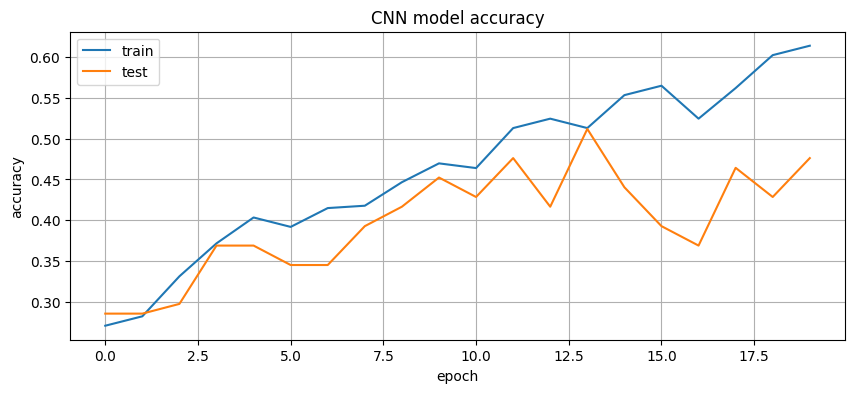

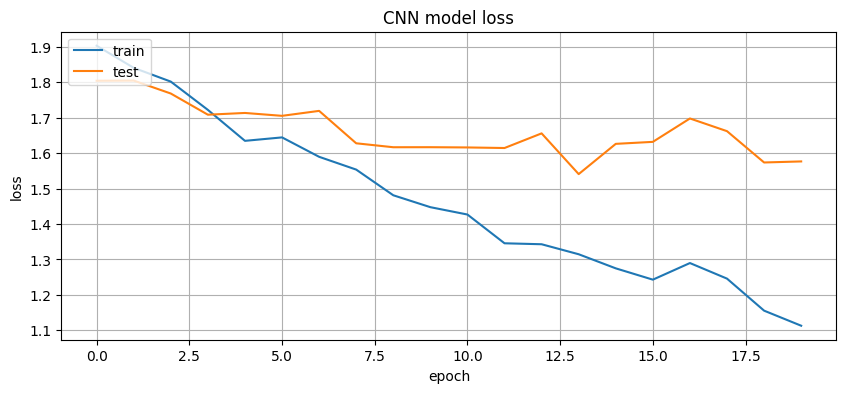

In [ ]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
11/11 [==============================] - 195s 18s/step - loss: 2.0410 - accuracy: 0.2334 - val_loss: 1.7736 - val_accuracy: 0.2976
Epoch 2/20
11/11 [==============================] - 192s 18s/step - loss: 1.7738 - accuracy: 0.3228 - val_loss: 1.6494 - val_accuracy: 0.3690
Epoch 3/20
11/11 [==============================] - 188s 17s/step - loss: 1.5874 - accuracy: 0.3833 - val_loss: 1.6065 - val_accuracy: 0.4286
Epoch 4/20
11/11 [==============================] - 193s 18s/step - loss: 1.4866 - accuracy: 0.4323 - val_loss: 1.5112 - val_accuracy: 0.4405
Epoch 5/20
11/11 [==============================] - 194s 18s/step - loss: 1.3261 - accuracy: 0.5216 - val_loss: 1.4190 - val_accuracy: 0.4881
Epoch 6/20
11/11 [==============================] - 200s 19s/step - loss: 1.2047 - accuracy: 0.5648 - val_loss: 1.3773 - val_accuracy: 0.5238
Epoch 7/20
11/11 [==============================] - 199s 18s/step - loss: 1.1280 - accuracy: 0.5879 - val_loss: 1.3035 - val_accuracy: 0.5476
Epoch 

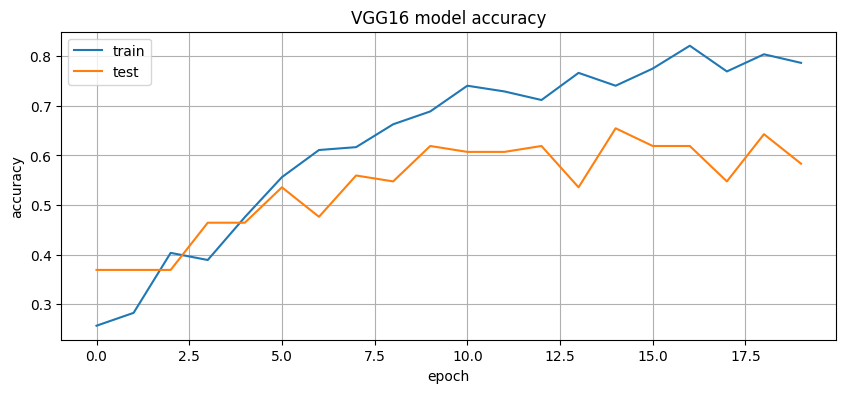

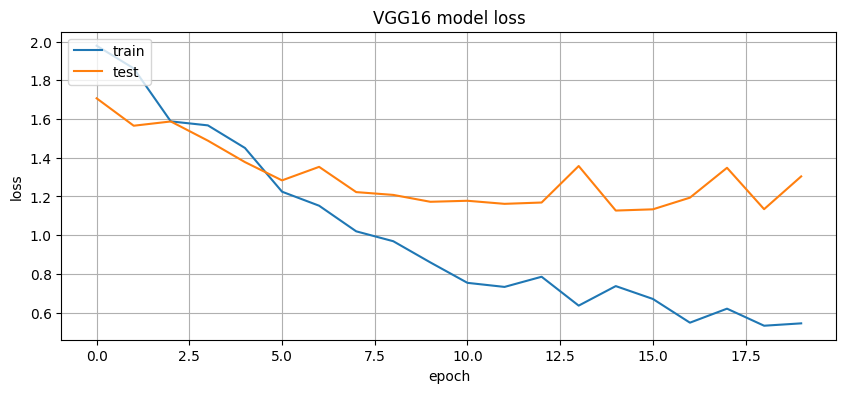

In [ ]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax")
])


In [ ]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
11/11 [==============================] - 78s 7s/step - loss: 2.1921 - accuracy: 0.2363 - val_loss: 2.1029 - val_accuracy: 0.1310
Epoch 2/20
11/11 [==============================] - 70s 6s/step - loss: 2.1016 - accuracy: 0.2421 - val_loss: 2.0136 - val_accuracy: 0.2024
Epoch 3/20
11/11 [==============================] - 81s 8s/step - loss: 1.9654 - accuracy: 0.2161 - val_loss: 1.9888 - val_accuracy: 0.2619
Epoch 4/20
11/11 [==============================] - 75s 7s/step - loss: 1.9275 - accuracy: 0.2478 - val_loss: 1.8699 - val_accuracy: 0.1667
Epoch 5/20
11/11 [==============================] - 76s 7s/step - loss: 1.8840 - accuracy: 0.2565 - val_loss: 1.9058 - val_accuracy: 0.2857
Epoch 6/20
11/11 [==============================] - 75s 7s/step - loss: 1.8986 - accuracy: 0.2767 - val_loss: 1.9275 - val_accuracy: 0.2143
Epoch 7/20
11/11 [==============================] - 74s 7s/step - loss: 1.8910 - accuracy: 0.2104 - val_loss: 1.8578 - val_accuracy: 0.2976
Epoch 8/20
11/11 [==

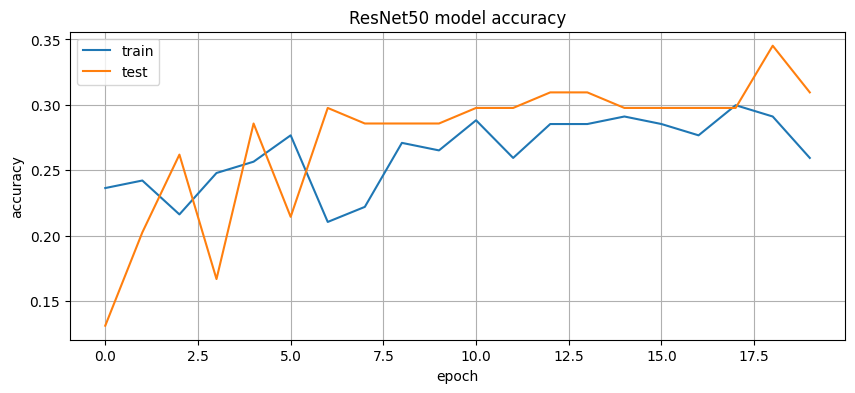

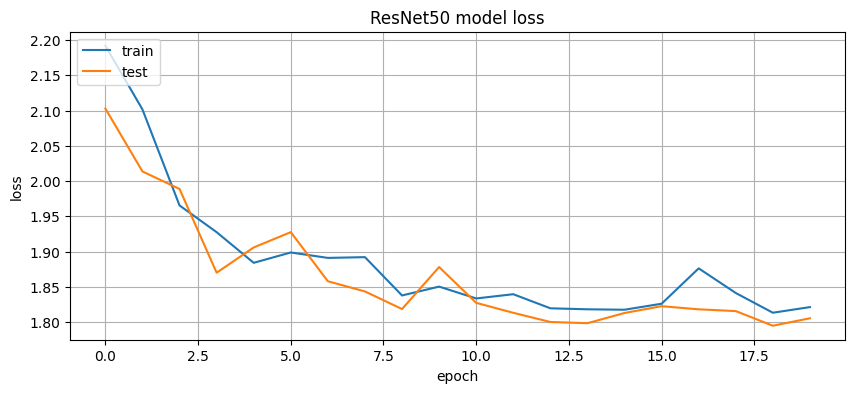

In [ ]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(7, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
11/11 [==============================] - 28s 979ms/step - loss: 1.9046 - accuracy: 0.2450 - val_loss: 1.7883 - val_accuracy: 0.2976
Epoch 2/20
11/11 [==============================] - 5s 471ms/step - loss: 1.7049 - accuracy: 0.3343 - val_loss: 1.7236 - val_accuracy: 0.3571
Epoch 3/20
11/11 [==============================] - 3s 300ms/step - loss: 1.6004 - accuracy: 0.3948 - val_loss: 1.6710 - val_accuracy: 0.3333
Epoch 4/20
11/11 [==============================] - 4s 358ms/step - loss: 1.4931 - accuracy: 0.4352 - val_loss: 1.6593 - val_accuracy: 0.4048
Epoch 5/20
11/11 [==============================] - 5s 411ms/step - loss: 1.4192 - accuracy: 0.4669 - val_loss: 1.6467 - val_accuracy: 0.4286
Epoch 6/20
11/11 [==============================] - 3s 296ms/step - loss: 1.2868 - accuracy: 0.5303 - val_loss: 1.6506 - val_accuracy: 0.4048
Epoch 7/20
11/11 [==============================] - 4s 357ms/step - loss: 1.1950 - accuracy: 0.5591 - val_loss: 1.6993 - val_accuracy: 0.4048
Epoch

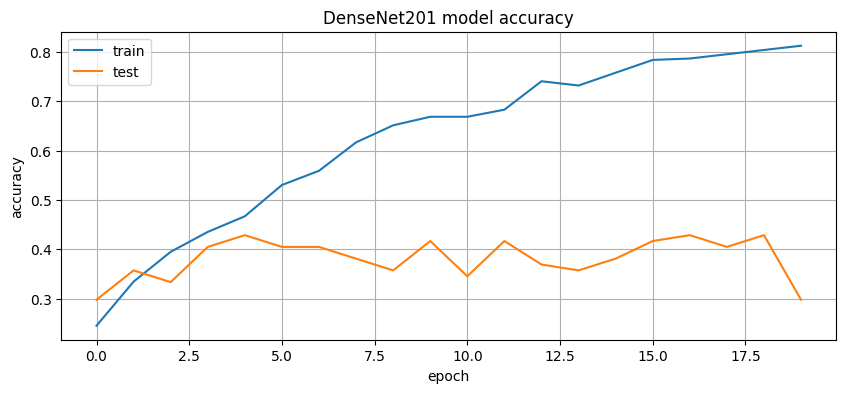

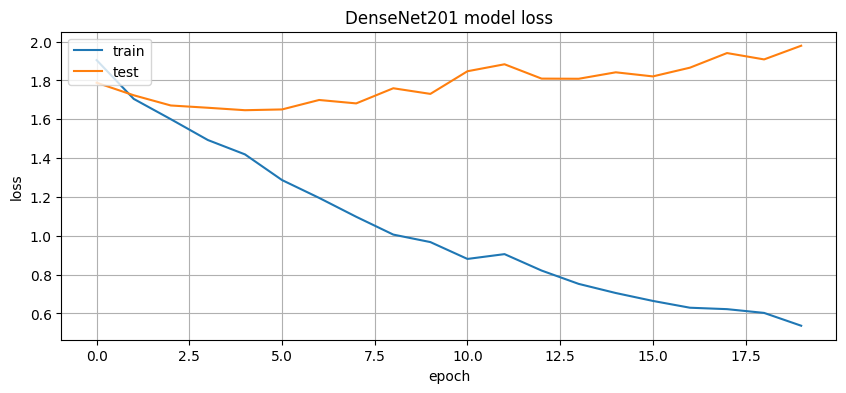

In [ ]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

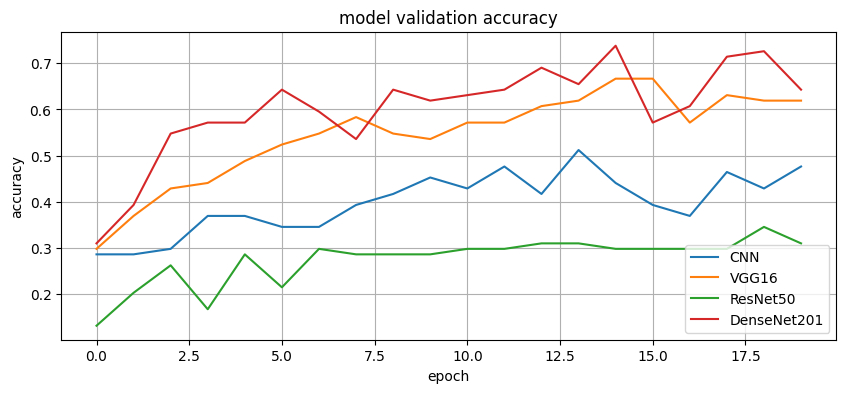

In [ ]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'Abrasions': 0,
 'Bruises': 1,
 'Burns': 2,
 'Cut': 3,
 'Ingrown_nails': 4,
 'Laceration': 5,
 'Stab_wound': 6}

Saving images.jpeg to images (3).jpeg
1/1 [==============================] - 4s 4s/step
images (3).jpeg
Bruises


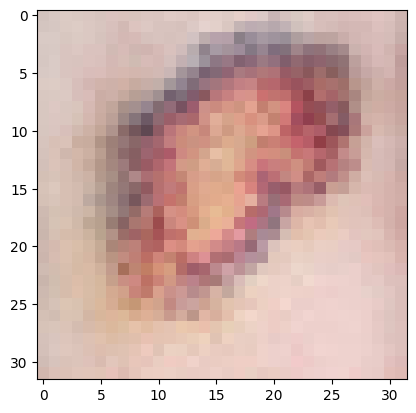

In [ ]:
# Menguji coba model
import numpy as np
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()

model = keras.models.load_model('model-wound-recognition.h5')

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('Abrasions')
  elif classes==1:
    print('Bruises')
  elif classes==2:
    print('Burns')
  elif classes==3:
    print('Cut')
  elif classes==4:
    print('Ingrown_nails')
  elif classes==5:
    print('Laceration')
  else:
    print('Stab_wound')

# Bagian Baru

In [ ]:
densenet_model.save('model-wound-recognition.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-wound-recognition.tflite', 'wb') as f:
  f.write(tflite_model)